In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances
import tf_nndistance

In [2]:
TRAIN = [line.rstrip() for line in open("data/modelnet40_ply_hdf5_2048/train_files.txt")]
TEST = [line.rstrip() for line in open("data/modelnet40_ply_hdf5_2048/test_files.txt")]
LABEL_NAMES = [line.rstrip() for line in open("data/modelnet40_ply_hdf5_2048/shape_names.txt")]

In [3]:
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

In [4]:
def visualize3D(x, y, z):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z)
    plt.show()

In [5]:
def pointCloudTransformation(pointCloud, angle, translation):
    transformMatrixZ = np.array([
                       [np.cos(angle), -np.sin(angle), 0],
                       [np.sin(angle), np.cos(angle) , 0],
                       [0            , 0             , 1]
                      ])
    
    transformMatrixY = np.array([
                       [np.cos(angle) , 0, np.sin(angle)],
                       [0             , 1, 0            ],
                       [-np.sin(angle), 0, np.cos(angle)]
                      ])
    
    transformMatrixX = np.array([
                       [1, 0            ,              0],
                       [0, np.cos(angle), -np.sin(angle)],
                       [0, np.sin(angle),  np.cos(angle)]
                      ])
    pointCloud =  np.dot(pointCloud, transformMatrixX)
    pointCloud =  np.dot(pointCloud, transformMatrixY)
    pointCloud =  np.dot(pointCloud, transformMatrixZ)
    
    
#     transformMatrixZ = tf.constant([[tp.cos(angle), -tp.sin(angle), 0], [tp.sin(angle), tp.cos(angle) , 0], [0,0,1]])
#     transformMatrixY = tf.constant([[tp.cos(angle),0, tp.sin(angle)], [0,0,1], [-tp.sin(angle), 0, tp.cos(angle)]])
#     transformMatrixX = tf.constant([[1, 0,0], [0,tp.cos(angle), -tp.sin(angle)], [0, tp.sin(angle), tp.cos(angle)]])
#     pointCloud = tf.tensordot(pointCloud, transformMatrixX, 1)
#     pointCloud = tf.tensordot(pointCloud, transformMatrixY, 1)
#     pointCloud = tf.tensordot(pointCloud, transformMatrixZ, 1)
    return pointCloud

In [6]:
def ReconstructImage(centers, noOfPoints, radius):
    
    centers = tf.tile(tf.expand_dims(centers, 2), tf.constant([1, 1, noOfPoints, 1]))
    shape_generate = [centers.shape[0].value, centers.shape[1].value, centers.shape[2].value, 1]
    
    phi = tf.random_uniform(shape_generate, minval=0, maxval=2*np.pi)
    phi = tf.concat([tf.cos(phi), tf.sin(phi), tf.ones(shape_generate)], axis = 3)
                         
    theta = tf.random_uniform(shape_generate, minval=0, maxval=np.pi)
    theta = tf.concat([tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis = 3)
                         
    rand_radius = tf.random_uniform(shape_generate, minval=0, maxval=radius)
    rand_radius = tf.tile(rand_radius, tf.constant([1, 1, 1, 3]))
    
    result = tf.add(tf.multiply(tf.multiply(theta, phi), rand_radius), centers)
    result = tf.reshape(result, [centers.shape[0].value, noOfPoints*centers.shape[1].value, 3])
    return result

In [ ]:
def Reconstruct_network(representation)

In [7]:
models = []
labels = []
for file in TRAIN:
    current_data, current_label = load_h5(file)
    for index in range(len(current_data)):
        temp = pointCloudTransformation(current_data[index], np.pi/2, 0)    
        models.append(temp)
        labels.append(current_label[index])
models = np.array(models)
labels = np.array(models)
print(models.shape)

(9840, 2048, 3)


In [68]:
def DistancePointCloud(A, B):
    expanded_a = tf.expand_dims(A, 1)
    expanded_b = tf.expand_dims(B, 0)
    distances = tf.reduce_sum(tf.squared_difference(expanded_a, expanded_b), 2)
    return distances
def createDenseCell(x,size,layer):
    with tf.variable_scope(layer):
        h1 = tf.contrib.layers.fully_connected(x, size,activation_fn=tf.nn.relu,scope='dense')
#         h2 = tf.contrib.layers.batch_norm(h1,center=True, scale=True,is_training=flag,scope='bn')
        return h1
with tf.device("/gpu"):
    tf.reset_default_graph()
    BATCH_SIZE = 32
    X_ = tf.placeholder('float', shape=[BATCH_SIZE, 2048, 3])
    X = tf.reshape(X_, [BATCH_SIZE, 2048, 3, 1])
    distance = tf.placeholder(tf.float32, shape=[2048, 2048])
    distance = tf.ones([2048, 2048])
    layer1 = tf.layers.conv2d(X     , 1500, [1, 3], activation=tf.nn.relu, padding="same")
    layer2 = tf.layers.conv2d(layer1, 1000 , [1, 3], activation=tf.nn.relu, padding="same")
    layer3 = tf.layers.conv2d(layer2, 512 , [1, 3], activation=tf.nn.relu, padding="same")
    # layer4 = tf.layers.conv2d(layer3, 256 , [1, 3], activation=tf.nn.relu, padding="same")
    layer4_pool = tf.layers.max_pooling2d(layer3, [2048, 1], [1, 1])
#     print(layer4_pool)
    fc1=tf.reshape(layer4_pool,[BATCH_SIZE,-1])
    fc2=createDenseCell(fc1,2048,"layer1")
    fc3=createDenseCell(fc2,512*3,"layer2")
    
    representation = tf.reshape(fc3, [BATCH_SIZE, 512, 3])
    output = ReconstructImage(representation, 4, 0.7)


# output = tf.squeeze(output)
# temp = tf.squeeze(X)
# #LOSS 
# D = DistancePointCloud(temp, output)
# print(X_.shape)
dists_forward,_,dists_backward,_=tf_nndistance.nn_distance(output,X_)
mindist=dists_forward
# dist0=mindist[0,:]
dists_forward=tf.reduce_mean(dists_forward)
dists_backward=tf.reduce_mean(dists_backward)
loss_nodecay=(dists_forward+dists_backward/2.0)*10000
loss=loss_nodecay
# loss=tf.losses.mean_squared_error(D, distance)

train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
init = tf.global_variables_initializer()

In [69]:
def createBatch(trainingData,trainingLabel,batch_size):
    batchtrainData=[]
    batchtrainLabel=[]
    n=len(trainingData)    
    for i in range (int(n/batch_size)):
        batchtrainData.append(trainingData[batch_size*i:min(batch_size*(i+1),n)])
        batchtrainLabel.append(trainingLabel[batch_size*i:min(batch_size*(i+1),n)])
    return np.array(batchtrainData),np.array(batchtrainLabel)

batchesData, batchesLabel = createBatch(models, labels, BATCH_SIZE)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print(sess.run(init))
    counter = 0
    for i in range(10):
        loss_epoch = 0.0
        for X_batch,Y_batch in zip(batchesData,batchesLabel):
    #         print(X_batch[0].shape)
            dd = euclidean_distances(X_batch[0], X_batch[0])
            _, loss_t = sess.run([train_op, loss], feed_dict={X_: X_batch})
    #         _, loss_t = sess.run([train_op, loss], feed_dict={X: mod,  distance:dd})
            loss_epoch += loss_t
            print("BATCH", loss_t)
        print(i, loss_epoch)
#             counter += 1

None
('BATCH', 365.48953)
('BATCH', 22136066.0)
('BATCH', 331.07584)
('BATCH', 428.88535)
('BATCH', 407.74744)
('BATCH', 452.52875)
('BATCH', 429.31509)
('BATCH', 397.55005)
('BATCH', 404.07858)
('BATCH', 413.60608)
('BATCH', 359.24368)
('BATCH', 317.59409)
('BATCH', 334.84348)
('BATCH', 422.4017)
('BATCH', 331.50211)
('BATCH', 402.84476)
('BATCH', 391.63016)
('BATCH', 371.05371)
('BATCH', 416.45389)
('BATCH', 396.89966)
('BATCH', 419.48886)
('BATCH', 363.14557)
('BATCH', 378.26617)
('BATCH', 367.76941)
('BATCH', 422.84555)
('BATCH', 400.64209)
('BATCH', 372.49942)
('BATCH', 414.76944)
('BATCH', 382.76419)
('BATCH', 423.09344)
('BATCH', 404.73297)
('BATCH', 386.58365)
('BATCH', 370.75217)
('BATCH', 353.05872)
('BATCH', 345.95773)
('BATCH', 320.99579)
('BATCH', 385.66208)
('BATCH', 441.09955)
('BATCH', 382.31372)
('BATCH', 333.72086)
('BATCH', 435.68665)
('BATCH', 386.36081)
('BATCH', 351.5369)
('BATCH', 372.34268)
('BATCH', 395.25613)


KeyboardInterrupt: 

In [71]:
with tf.Session() as sess:
    sess.run(init)
    counter = 0
    for X_batch,Y_batch in zip(batchesData,batchesLabel):

        reconstruct= sess.run(output, feed_dict={X_: X_batch})
        break
     

In [76]:
reconstructed=reconstruct[1]

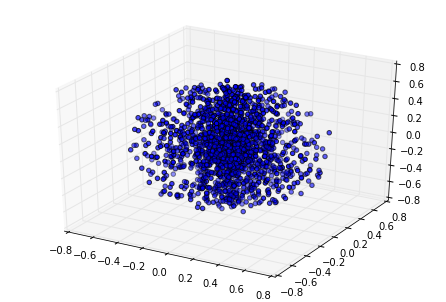

In [77]:
visualize3D(reconstructed[:,0],reconstructed[:,1],reconstructed[:,2])

In [ ]:
tf.reset_default_graph()
A = tf.constant([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
B = tf.constant([[1, 1, 1], [2, 2, 2], [3, 3, 3]])

expanded_a = tf.expand_dims(A, 1)
expanded_b = tf.expand_dims(B, 0)
distances = tf.reduce_sum(tf.squared_difference(expanded_a, expanded_b), 2)
with tf.Session() as sess:
    print(sess.run([distances]))

In [ ]:
[[0, 2, 8],
       [2, 0, 2],
       [8, 2, 0]]

In [ ]:
#Read Data plot 3d points
#Compress data code
#Reconstruct by making sphere and putting random points in that 
